# Background
This Dataset comes from https://www.insideairbnb.com
It is the most recent set as of this project, dated October 19, 2023.

I will be using this to learn about listings in Dallas. Specifically, I will use characteristics of listings as independent variables, in order to determine the effect that they have on pricing.

# Importing, understanding, and cleaning the data

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import directory
import folium
import math

In [63]:
#Read in Data
df_raw = pd.read_csv(directory.path + 'RawData/listings.csv')

In [64]:
pd.set_option('display.max_columns', None)
df_raw.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [65]:
#Start data cleaning process.
#Drop unnecessary columns.
df = df_raw.loc[:,['id', 'name','host_id','host_since', 'host_location','host_acceptance_rate','host_is_superhost', 'neighbourhood_cleansed','latitude','longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

#Changes superhost true/false values to bianary values
df['host_is_superhost'] = df['host_is_superhost'].replace({'t' : 1 , 'f' : 0})

#Change value of host_since to a date format
df['host_since'] = df['host_since'].astype('datetime64[ns]')

#Create new columns for price and acceptance rate. Changes the data type to a float value and removes the signs
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

#Cleaning Outliers
#Drop listings with less than 1 review
df.drop(df[df['number_of_reviews'] < 1 ].index, inplace = True)

#Remove listings with a 0% Acceptance Rate
df.drop(df[df['host_acceptance_rate'] == 0].index, inplace = True)

#Restrict listings with prices greater than $1000
df.drop(df[df['price'] >= 1000].index, inplace = True)

df = df.reset_index(drop = True)

df[['accommodates','bedrooms','beds','price','host_acceptance_rate','number_of_reviews','review_scores_rating']].describe().round(2)

,accommodates,bedrooms,beds,price,host_acceptance_rate,number_of_reviews,review_scores_rating
count,4528.00,3919.00,4502.00,4528.00,4291.00,4528.00,4528.00
mean,5.03,2.02,2.60,156.70,0.95,44.79,4.72
std,3.38,1.21,1.98,121.52,0.10,79.32,0.48
min,1.00,1.00,1.00,10.00,0.05,1.00,0.00
25%,2.00,1.00,1.00,85.00,0.96,5.00,4.67
50%,4.00,2.00,2.00,120.00,0.99,17.00,4.85
75%,6.00,3.00,3.00,185.00,1.00,50.00,5.00
max,16.00,8.00,22.00,999.00,1.00,1097.00,5.00


Lets change the neighbourhood variables to be bianary variables so that they can be used for regressions. Both a fixed effects regression and future machine learning applications.

To do this, we will use the neighbourhood_cleansed category, which has already so nicely categorized the listings into 14 neighbourhood bins.
These will be used as 'dummy variables', with a boolean value of 'True' for only their district, and a 'False' value in all 13 other categories. Note, this was done using the neighbourhood_cleansed category, instead of the host_neighbourhood category because of the uniform binning process. host_neighbourhood, while also describing neighbourhood, was not an accurate descriptor.

We will also follow a similar process with room_type. This was done with room_type rather than property_type because room_type contained more useful data, while property_type contained too many small categories to be useful.

In [66]:
#df.neighbourhood_cleansed.value_counts()
df['nb1'] = (df.neighbourhood_cleansed=="District 1")
df['nb2'] = (df.neighbourhood_cleansed=="District 2")
df['nb3'] = (df.neighbourhood_cleansed=="District 3")
df['nb4'] = (df.neighbourhood_cleansed=="District 4")
df['nb5'] = (df.neighbourhood_cleansed=="District 5")
df['nb6'] = (df.neighbourhood_cleansed=="District 6")
df['nb7'] = (df.neighbourhood_cleansed=="District 7")
df['nb8'] = (df.neighbourhood_cleansed=="District 8")
df['nb9'] = (df.neighbourhood_cleansed=="District 9")
df['nb10'] = (df.neighbourhood_cleansed=="District 10")
df['nb11'] = (df.neighbourhood_cleansed=="District 11")
df['nb12'] = (df.neighbourhood_cleansed=="District 12")
df['nb13'] = (df.neighbourhood_cleansed=="District 13")
df['nb14'] = (df.neighbourhood_cleansed=="District 14")

In [67]:
df.room_type.value_counts()
df['entire_home'] = (df.room_type=='Entire home/apt')
df['private_room'] = (df.room_type=='Private room')
df['shared_room'] = (df.room_type=='Shared room') #This value is not used upon the removal of missing values.
#df['shared_room'].value_counts()
#df.info()

Perfect, the dummy variables were formed exactly like we had wanted.

Now we may need to standardize the variables. We will for clusters, researching if I should for correlation and fixed effects
Now let's standardize the dataframe. To do this, we will drop any bianary columns, as well as any other non-numeric columns

Then, we will create a new dataframe (df_stnd) with the appropriate columns, and will apply a standardization (min-max) formula to it.

Many machine learning algorithms require a scale of [0,1] to work, so standardizing the columns to this scale is necessary. This will also allow us to compare across independent variables (aka features). So we will be able to determine how different categories affect predictions when compared with one another

In [68]:
cols = df.columns
cols = cols.drop(['longitude','host_location','host_is_superhost','host_since','host_id','id','name','latitude','neighbourhood_cleansed','room_type','nb1','nb2','nb3','nb4','nb5','nb6','nb7','nb8','nb9','nb10','nb11','nb12','nb13','nb14','entire_home','private_room','shared_room'])
cols

Index(['host_acceptance_rate', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')

In [69]:
df_stnd = df.copy()
for var in cols:
    df_stnd[var] = (df[var] - np.min(df[var]))/(np.max(df[var]) - np.min(df[var]))

#Drop missing values
df_stnd = df_stnd.dropna().reset_index(drop=True)
df_stnd.describe().round(2)

,id,host_id,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_communication,review_scores_location,review_scores_value
count,2.792000e+03,2.792000e+03,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00,2792.00
mean,4.035576e+17,1.794650e+08,0.96,0.47,32.81,-96.79,0.30,0.15,0.09,0.16,0.03,0.48,0.04,0.95,0.95,0.96,0.93,0.93
std,4.021720e+17,1.566153e+08,0.09,0.50,0.06,0.04,0.23,0.17,0.10,0.12,0.07,0.38,0.07,0.07,0.08,0.08,0.09,0.09
min,6.187800e+04,4.342200e+04,0.00,0.00,32.63,-96.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00
25%,4.233252e+07,4.304234e+07,0.96,0.00,32.78,-96.82,0.13,0.00,0.00,0.09,0.00,0.27,0.01,0.93,0.94,0.95,0.90,0.90
50%,5.548228e+17,1.171225e+08,0.99,0.00,32.80,-96.79,0.20,0.14,0.05,0.12,0.01,0.32,0.02,0.97,0.97,0.99,0.96,0.95
75%,7.989672e+17,3.053501e+08,1.00,1.00,32.82,-96.77,0.40,0.29,0.14,0.19,0.01,1.00,0.05,1.00,1.00,1.00,0.99,0.98
max,1.000199e+18,5.388672e+08,1.00,1.00,33.02,-96.48,1.00,1.00,0.62,1.00,1.00,1.00,0.92,1.00,1.00,1.00,1.00,1.00


Now that we have normalized our data and dropped our missing values, lets plot the locations. Then, we will split the data into train and test dataframes.

In [70]:
#Map centered on Downtown Dallas (coordinates 32.7791, -96.8003) with a `zoom_start` value of 11
f = folium.Figure(width=800, height=500)
m = folium.Map(location=[32.7791, -96.8003], zoom_start=11, tiles='CartoDB positron').add_to(f)

for point in range(0, len(df_stnd)):
    lat = df_stnd['latitude'][point]
    long = df_stnd['longitude'][point]
    temp = lat,long
    folium.CircleMarker(temp,radius=0.001).add_to(m)
m

In [71]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_stnd, test_size = 0.2, random_state = 1)

In [72]:
train_df

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_communication,review_scores_location,review_scores_value,nb1,nb2,nb3,nb4,nb5,nb6,nb7,nb8,nb9,nb10,nb11,nb12,nb13,nb14,entire_home,private_room,shared_room
1293,53612067,Townhouse in Dallas · ★4.75 · 1 bedroom · 1 be...,66495713,2016-04-09,"Los Angeles, CA",0.968421,0.0,District 10,32.886080,-96.732090,Entire home/apt,0.066667,0.000000,0.000000,0.140546,0.005025,1.000000,0.031934,0.950,0.9450,0.9800,0.9100,0.9525,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
2542,922377778530147059,Rental unit in Dallas · ★4.67 · 1 bedroom · 1 ...,126031305,2017-04-15,"Cape Coral, FL",1.000000,0.0,District 10,32.910824,-96.727952,Entire home/apt,0.133333,0.000000,0.000000,0.060667,0.015075,0.022262,0.004562,0.934,0.9575,0.9575,0.7925,0.9575,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
936,47888557,Rental unit in Dallas · ★4.57 · 1 bedroom · 2 ...,386021104,2021-01-25,"Dallas, TX",1.000000,0.0,District 14,32.823820,-96.767260,Entire home/apt,0.200000,0.000000,0.047619,0.069767,0.000000,1.000000,0.138686,0.914,0.8975,0.9525,0.9425,0.8800,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
1725,676166145893133073,Rental unit in Dallas · ★4.71 · 2 bedrooms · 2...,439019396,2022-01-04,"Dallas, TX",0.978947,0.0,District 14,32.807608,-96.760724,Entire home/apt,0.200000,0.142857,0.047619,0.112235,0.010050,0.078362,0.018248,0.942,0.9050,0.9750,0.7625,0.8800,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
790,45070235,Condo in Dallas · ★4.93 · 1 bedroom · 1 bed · ...,20618407,2014-08-27,"Dallas, TX",0.936842,1.0,District 2,32.811280,-96.778150,Entire home/apt,0.133333,0.000000,0.000000,0.058645,0.145729,0.323241,0.011861,0.986,1.0000,0.9825,1.0000,1.0000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,986511427610488340,Home in Dallas · ★New · 3 bedrooms · 6 beds · ...,117556542,2017-02-22,"Missouri, United States",1.000000,0.0,District 7,32.768753,-96.720276,Entire home/apt,0.466667,0.285714,0.238095,0.221436,0.005025,0.323241,0.000000,1.000,1.0000,1.0000,1.0000,1.0000,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
905,47322558,Rental unit in Dallas · ★4.71 · 4 bedrooms · 6...,372592509,2020-10-19,"Dallas, TX",0.989474,0.0,District 14,32.784240,-96.800330,Entire home/apt,0.600000,0.428571,0.238095,0.297270,0.005025,0.158504,0.005474,0.942,0.9650,1.0000,0.9275,0.8925,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
1096,50791232,Home in Dallas · ★4.87 · 4 bedrooms · 7 beds ·...,171918351,2018-02-06,"Houston, TX",0.978947,0.0,District 1,32.755310,-96.831970,Entire home/apt,0.733333,0.428571,0.285714,0.070779,0.005025,1.000000,0.063869,0.974,0.9650,0.9500,0.9625,0.9500,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
235,23397511,Rental unit in Dallas · ★4.59 · 1 bedroom · 1 ...,23459662,2014-11-07,"Dallas, TX",1.000000,0.0,District 2,32.777300,-96.795040,Entire home/apt,0.066667,0.000000,0.000000,0.113246,0.005025,0.051647,0.115876,0.918,0.9300,0.9500,0.8975,0.9000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [73]:
test_df

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_communication,review_scores_location,review_scores_value,nb1,nb2,nb3,nb4,nb5,nb6,nb7,nb8,nb9,nb10,nb11,nb12,nb13,nb14,entire_home,private_room,shared_room
620,40014545,Rental unit in Dallas · 1 bedroom · 2 beds · 1...,108514926,2016-12-26,"Houston, TX",0.957895,0.0,District 14,32.790400,-96.791840,Entire home/apt,0.133333,0.000000,0.047619,0.126390,0.020101,0.105076,0.000912,0.600,1.0000,0.6250,0.8750,0.7500,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
2444,900343417074776747,Home in Dallas · 2 bedrooms · 3 beds · 2.5 baths,435498255,2021-12-10,"Dallas, TX",0.968421,0.0,District 2,32.802025,-96.785714,Entire home/apt,0.533333,0.142857,0.095238,0.369060,0.000000,0.710597,0.000000,1.000,1.0000,1.0000,1.0000,1.0000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1696,665997435074921869,Rental unit in Dallas · ★4.82 · 1 bedroom · 2 ...,363191315,2020-08-18,"Dallas, TX",0.989474,0.0,District 2,32.800302,-96.780574,Entire home/apt,0.200000,0.000000,0.047619,0.086957,0.000000,0.323241,0.081204,0.964,0.9700,0.9900,0.9175,0.9550,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2249,850771492986965334,Townhouse in Dallas · ★5.0 · 4 bedrooms · 7 be...,270320740,2019-06-21,"Dallas, TX",0.978947,1.0,District 2,32.807067,-96.822700,Entire home/apt,0.733333,0.428571,0.285714,0.419616,0.010050,0.323241,0.007299,1.000,1.0000,1.0000,0.9725,0.9725,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1837,715971174479056310,Rental unit in Dallas · ★4.94 · 1 bedroom · 1 ...,423884185,2021-09-20,"Harrison, NJ",0.957895,1.0,District 6,32.796700,-96.821040,Entire home/apt,0.066667,0.000000,0.000000,0.141557,0.020101,0.323241,0.046533,0.988,0.9950,0.9750,0.9625,0.9750,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,48776487,Rental unit in Dallas · ★4.56 · 2 bedrooms · 3...,372592509,2020-10-19,"Dallas, TX",0.989474,0.0,District 14,32.780700,-96.799820,Entire home/apt,0.333333,0.142857,0.095238,0.151668,0.005025,0.158504,0.034672,0.912,0.8975,0.9675,0.9750,0.9050,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
1114,51178473,Home in Dallas · ★4.76 · 4 bedrooms · 4 beds ·...,122082073,2017-03-22,"Coral Springs, FL",1.000000,0.0,District 2,32.805580,-96.825740,Entire home/apt,0.466667,0.428571,0.142857,0.247725,0.000000,1.000000,0.070255,0.952,0.9550,0.9625,0.9350,0.9300,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2548,924023241417913142,Rental unit in Dallas · ★4.88 · 1 bedroom · 1 ...,162733539,2017-12-15,"Dallas, TX",1.000000,0.0,District 2,32.807650,-96.816880,Entire home/apt,0.066667,0.000000,0.000000,0.065723,0.000000,0.042743,0.006387,0.976,0.9700,0.9700,0.9700,0.9700,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
492,35833954,Rental unit in Dallas · ★4.88 · 1 bedroom · 2 ...,156543716,2017-10-28,"Dallas, TX",1.000000,0.0,District 2,32.777600,-96.795400,Entire home/apt,0.200000,0.000000,0.047619,0.105157,0.145729,0.323241,0.006387,0.976,1.0000,1.0000,0.9375,0.9700,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


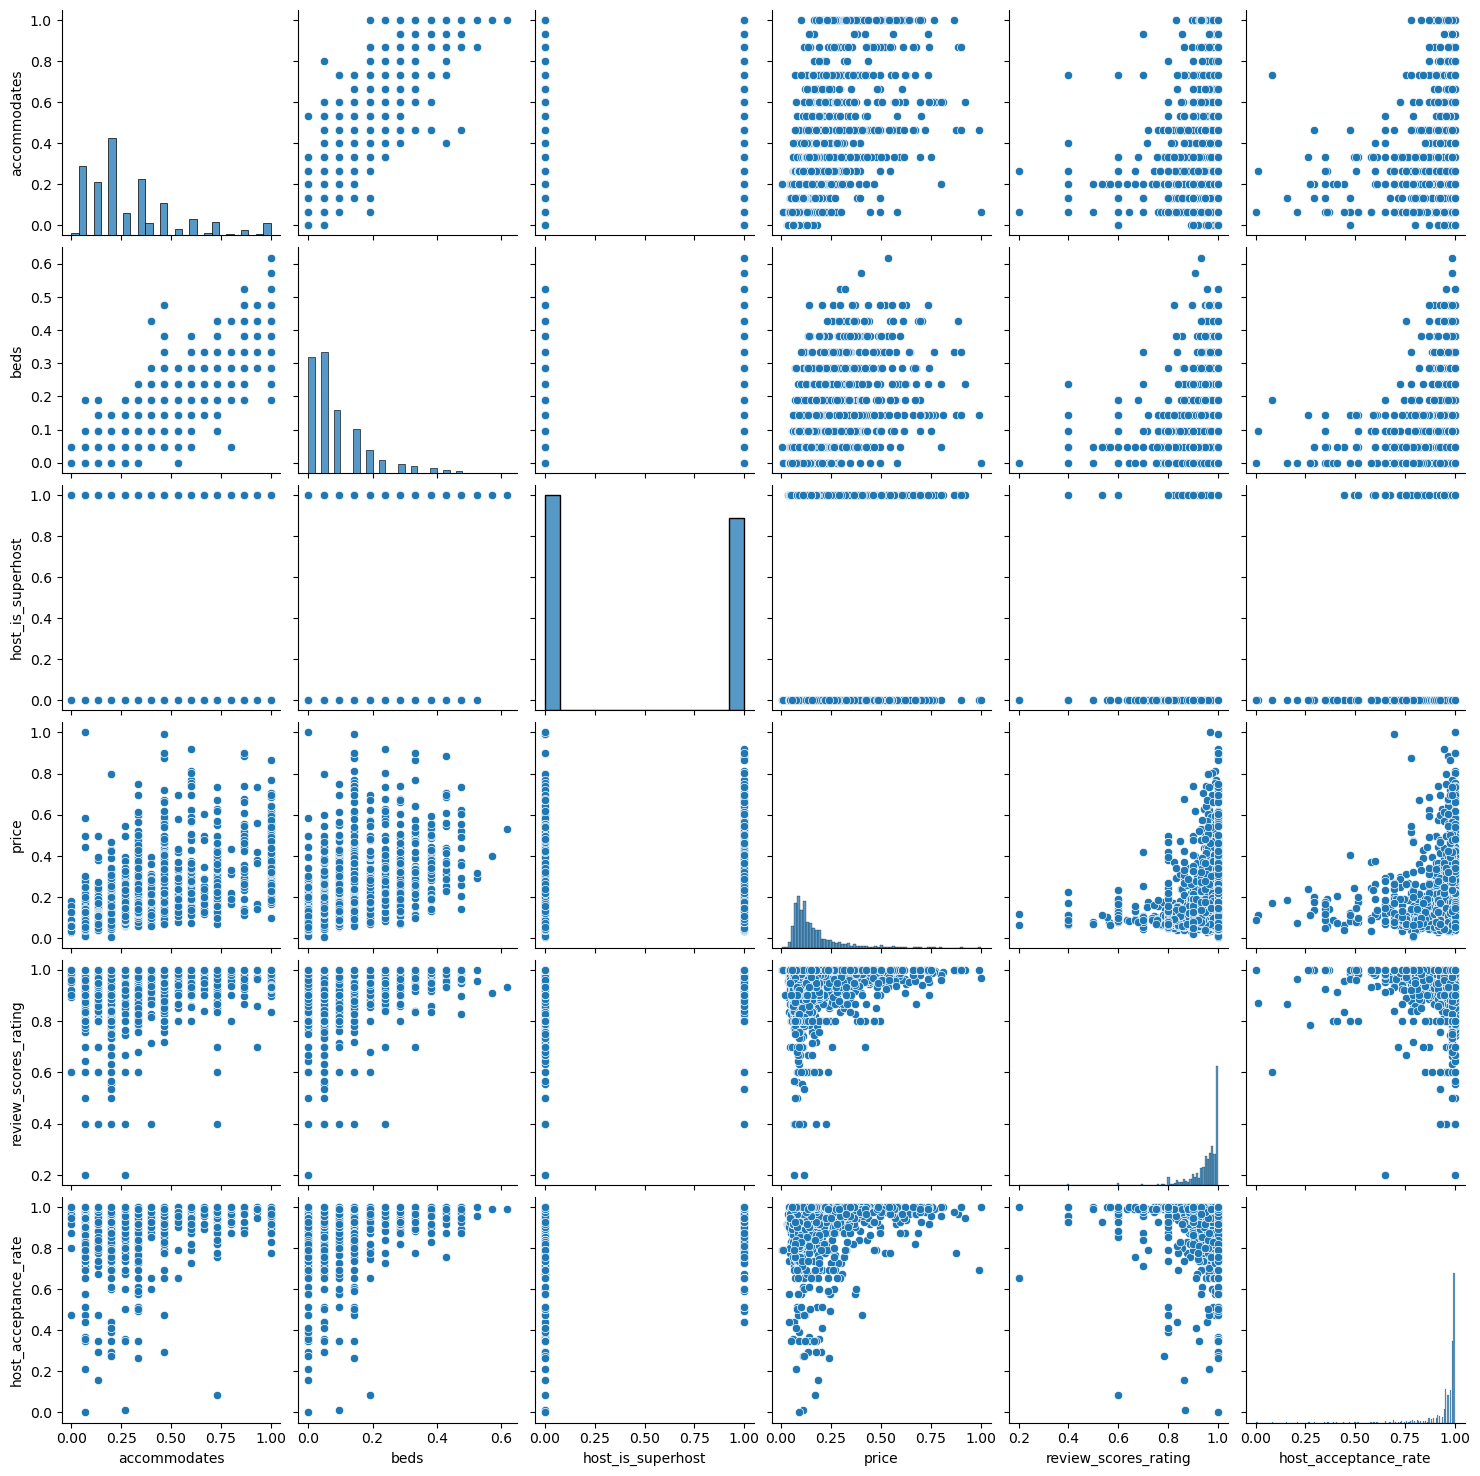

In [74]:
bnb_char = ['accommodates','beds','host_is_superhost','price','review_scores_rating','host_acceptance_rate']
sns.pairplot(df_stnd[bnb_char])
plt.show()
#Extreme outliers for price, accommodates, host_acceptance rate (0)

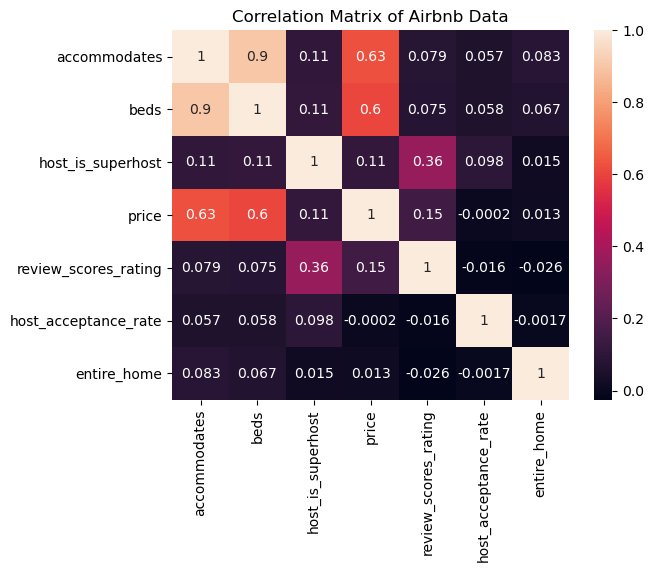

In [75]:
df_Corr1 = df_stnd[['accommodates','beds','host_is_superhost','price','review_scores_rating','host_acceptance_rate','entire_home']].copy()
#Neighbourhood Variables will need to be binned in order to gather correlation info
#df_Corr = df[['review_scores_rating','review_scores_accuracy','review_scores_communication','review_scores_location','review_scores_value','minimum_nights','maximum_nights']].copy()
#df_Corr.info()
#df_Corr
corr_matrix = df_Corr1.corr()

sns.heatmap(corr_matrix, annot=True)

plt.title('Correlation Matrix of Airbnb Data')

plt.show()

For many of these features, there is not a high correlation, so multicolinearity will not be an issue. Accommodates/Beds are very highly correlated, so one will be dropped from the regression. Price has a >50% correlation with both price and beds, but price will serve as our dependent variable, so this is ok. Lastly, host_is_superhost has a correlation of .36, which does represent moderate correlation. For this regression, we will continue to use it.

Now that I have the data prepared and split into train/test sets, it is time for regressions

In [76]:
import statsmodels.api as sm
from patsy import dmatrices
from linearmodels.panel import PanelOLS

train_df['id'] = 1
train_df['time'] = 1
data_panel = train_df.set_index(['id','time'])
dependent = data_panel.price

exog = sm.add_constant(data_panel[['accommodates','host_is_superhost','review_scores_rating','entire_home','nb2','nb3','nb4','nb5','nb6','nb7','nb8','nb9','nb10','nb11','nb12','nb13','nb14']])
modNFE = PanelOLS(dependent, exog, entity_effects=False)
resNFE = modNFE.fit(cov_type='unadjusted')
print(resNFE)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.4305
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2233   R-squared (Within):               0.0000
Date:                Tue, Dec 05 2023   R-squared (Overall):              0.4305
Time:                        21:54:14   Log-likelihood                    2110.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      98.483
Entities:                           1   P-value                           0.0000
Avg Obs:                       2233.0   Distribution:                 F(17,2215)
Min Obs:                       2233.0                                           
Max Obs:                       2233.0   F-statistic (robust):             98.483
                            

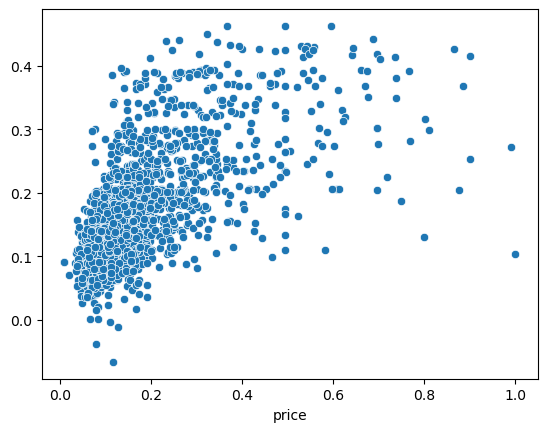

In [77]:
y_res = dependent-resNFE.resids

sns.scatterplot(x = dependent, y = y_res)
plt.show()

According to our R-squared value, these variables account for 43% of the variation in price.

As for the coefficients, these are a bit more difficult to interperet because the data is normalized. The accommodates correlation of .3588 generally means that a .3588 unit increase in price is associated with a one standard deviation increase in the number of people the Airbnb can accommodate, assuming all other variables in the model are constant.

But what does that mean? I will explain more later.

The most important point is that our model currently is invalid. The fanning effect of the plot of our model implies the presence of heteroskedasticity, so we will need to explore other options to interperet our data.

# 4. Learning about hosts

Here, I will create a new dataframe for hosts. This will allow me to check if hosts that manage more than one listing charge a higher or lower price on average. This idea will also be used for superhost status.

In [19]:
df_hosts = df_stnd.groupby(['host_id','host_is_superhost']).agg({'id': 'count','price': 'mean'}).reset_index()
df_hosts.columns = ['host_id', 'isSuperhost', 'numListings','avgPrice']
df_hosts

,host_id,isSuperhost,numListings,avgPrice
0,43422,1.0,1,0.350859
1,71423,0.0,1,0.111223
2,89845,0.0,1,0.116279
3,146477,1.0,1,0.085945
4,182325,0.0,2,0.104651
...,...,...,...,...
1255,532405979,0.0,3,0.082575
1256,532926597,0.0,1,0.112235
1257,533203036,0.0,1,0.055612
1258,533387561,0.0,1,0.097068


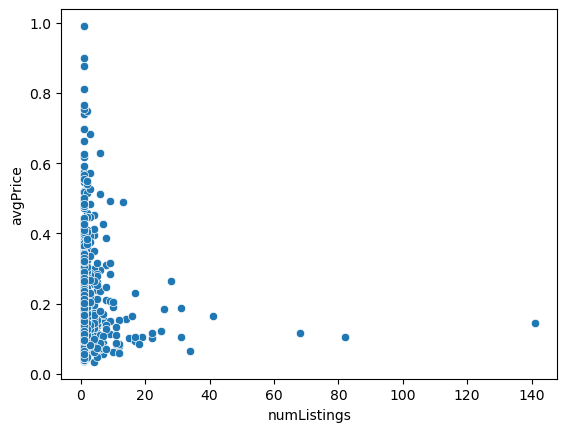

In [20]:
sns.scatterplot(data=df_hosts, x = 'numListings', y = 'avgPrice')
plt.show()

In [21]:
#Lets separate data on hosts with more than 20 listings. This will help us gather more insights on both groups
df2 = df_hosts.copy()
df_bigListingHosts = df_hosts.copy()
df2.drop(df2[df2['numListings'] >= 20].index, inplace = True)
df_bigListingHosts.drop(df_bigListingHosts[df_bigListingHosts['numListings'] < 20].index, inplace = True)